In [15]:
# !wget -O miyajima_sample.csv "https://github.com/tksakaki/kspub_ds_text_analytics/tree/main/Chapter06/text/miyajima_sample.csv"

In [16]:
from collections import Counter
import sys
sys.path.append("/Users/ruinz/.pyenv/versions/3.9.5/lib/python3.9/site-packages")
import spacy
import pandas as pd

# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'できる')

# 口コミデータの読み込み
df = pd.read_csv('./miyajima_sample.csv', encoding='utf-8',
                 parse_dates=['旅行の時期'])

# 口コミに含まれている空行を削除
df['口コミ'] = df['口コミ'].replace('\n+', '\n', regex=True)

nlp = spacy.load('ja_ginza')

# 出現する単語をリストに追加
words = []
for doc in nlp.pipe(df['口コミ'] ):
    words.extend([token.lemma_ for token in doc
                  if token.pos_ in include_pos and
                  token.lemma_ not in stopwords])

# 単語の頻度をカウント
counter = Counter(words)

print('count word')
for word, count in counter.most_common(10):
    print(f'{count:>5} {word}')

count word
  209 宮島
  133 行く
   96 食べる
   84 もみじ
   77 思う
   74 厳島神社
   66 牡蠣
   52 水族館
   52 鹿
   48 お店


In [17]:
# 口コミの件数を算出　
count = len(df)
print('口コミの件数', count)

# 口コミの平均文字数を算出
word_count = 0
for review in df['口コミ']:
    word_count += len(review)

ave = word_count / count
print('口コミの平均文字数', round(ave, 1))

口コミの件数 176
口コミの平均文字数 174.9


In [18]:
df

,居住地,年代,性別,旅行の時期,同行者,評価,タイトル,口コミ
0,広島,50代,男性,2021-10-01,家族,とても良い,まあきてみんさい,自然の景色 雅な社殿 ときめきいっぱいの商店街 海のにおい いいよお
1,広島,30代,女性,2021-10-01,友達,とても良い,魅力満載のワンダーアイランドです！,パワースポットでもある厳島神社を参拝したり、牡蠣やもみじ饅頭、穴子飯をはじめとしたグルメは有...
2,広島,30代,女性,2021-10-01,家族,とても良い,宮島グルメ,宮島のグルメを楽しむために母と訪問しました。昼食は、牡蠣屋という牡蠣料理専門店で牡蠣屋定食を...
3,広島,10代,男性,2021-10-01,カップル・夫婦,とても良い,牡蠣の聖地,牡蠣好きには堪らないです！！
4,広島,20代,女性,2021-10-01,友達,とても良い,宮島観光,試験の帰りに宮島へ寄りました。フェリーから降りてすぐに昼食をとろうとなり、商店街を歩きました...
...,...,...,...,...,...,...,...,...
171,愛媛,50代,男性,2008-08-01,ビジネス,とても良い,街並み,観光気分を味わえる。街並みが綺麗である。
172,広島,50代,男性,2007-09-01,家族,とても良い,宮島へ,広島で働くことが決まったので、家族で広島を見学に来ました。せっかくなので、観光地の宮島へ行き...
173,広島,10代,男性,2003-12-01,家族,普通,可もなく不可もなく,幼い頃に行くのは楽しいが大学生、社会人になるにつれ行く意欲が湧かない
174,広島,10代,男性,2001-12-01,カップル・夫婦,とても良い,宮島はとてもいい場所！！！！,シカが可愛かった❤


## 口コミの共起ネットワーク

In [20]:
# analyze_cooccurrency_miyajima.py


# 使用する単語の品詞とストップワードの指定
include_pos = ('NOUN', 'PROPN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう',
             'なる', 'ほう', 'いる', 'くる', 'お', 'つ', 'おる', 'とき', 'しまう',
             'いく', 'みる', 'ため', 'ところ', '際', '他', '時', '中', '方', '目', 
             '回', '年', '点', '前', '後', '思う', '行く')



In [21]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(sents, token_length='{2,}'):
    token_pattern=f'\\b\\w{token_length}\\b'
    count_model = CountVectorizer(token_pattern=token_pattern)

    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1
    Xc = (X.T * X) 
    return words, word_counts, Xc, X

In [23]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [24]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

In [26]:
# 口コミを解析し共起を算出 
sents = []
for doc in nlp.pipe(df['口コミ']):
    sents.extend([' '.join(extract_words(sent, include_pos, stopwords))
                  for sent in doc.sents])

words, word_counts, Xc, X = count_cooccurrence(sents, token_length='{1,}')

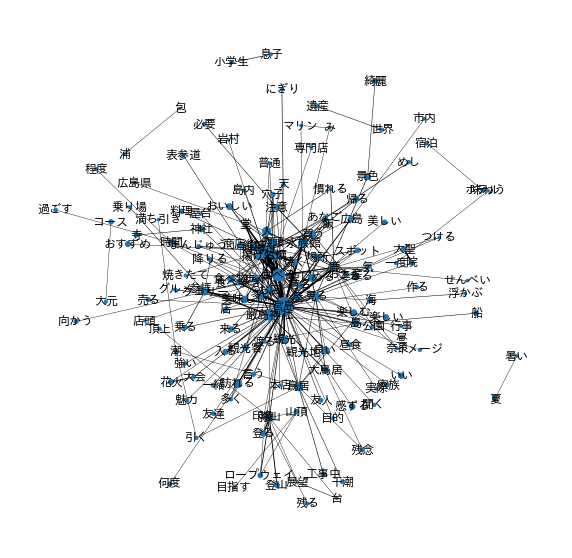

In [28]:
#　ネットワークの生成
sents = []
G = create_network(words, word_counts, Xc, 0.015)

#静的ネットワークの描画
pyplot_network(G)

#動的ネットワークの描画
pyvis_G = nx2pyvis_G(G)
pyvis_G.show('mygraph_miyajima.html')


In [30]:
import re

# 「鳥居」と「残念」という単語が含まれている口コミを表示
print('year', 'review')
for doc in nlp.pipe(df['口コミ']):
    for sent in doc.sents:
        sent = sent.text
        if re.search('鳥居', sent) and re.search('残念', sent):
            date = df[df['口コミ'] == doc.text]['旅行の時期']
            date = date.iloc[-1]
            sent = re.sub('\n', '', sent)
            print(date.year, sent)

year review
2021 鳥居を見ましたが、改修工事をしていたため全貌を見れず残念でした。
2020 厳島神社の大鳥居が改装中で幕に覆われていたのは残念でしたが、その分、秋の行楽シーズンにしては空いていて本社拝殿をじっくり歩くことができました。
2020 大鳥居が見えないのは残念ですが、夜は、保存修理中の大鳥居がライトアップされて金色に輝き、これはこれで貴重な景色だと思います。
2019 ただ、観光のメインである大鳥居が修繕中だったのが残念でした。
2019 鳥居が工事中で、記念撮影をしたかったですが、残念でした。
2019 当時、厳島神社の大鳥居が工事中で残念でしたが、宮島花火大会名物の水上花火は圧巻の美しさでした。
2019 友人は楽しんでいましたが、やはり目玉の鳥居を見ることができなかったのは残念です。
2019 鳥居をメインに見に来ましたが干潮の時刻を過ぎていたため鳥居の真下までは行けなかったのと曇りだったのが少し残念でした。


In [37]:
for doc in nlp.pipe(df['口コミ']):
    print("0000000000000000000000000000000000000")
    for sent in doc.sents:  
      print(sent)
      print("=====================")
        

0000000000000000000000000000000000000
自然の景色　
雅な社殿　ときめきいっぱいの商店街　
海のにおい　いいよお
0000000000000000000000000000000000000
パワースポットでもある厳島神社を参拝したり、牡蠣やもみじ饅頭、穴子飯をはじめとしたグルメは有名で食べ歩きを楽しめます。


また、カヤックや弥山登山などアクティビティも充実。

おすすめは、商店街の裏路地を散策することです。

商店街の賑やかさとはまた違う雰囲気で、落ち着いた雰囲気のカフェやレトロな文具店などがあり、ゆったりとした時間を過ごすことができます。

和風旅館もあり、世界遺産の島に宿泊できる贅沢も味わえます。
0000000000000000000000000000000000000
宮島のグルメを楽しむために母と訪問しました。
昼食は、牡蠣屋という牡蠣料理専門店で牡蠣屋定食をいただきました。
牡蠣屋定食は、焼き牡蠣、カキフライ、牡蠣飯など、牡蠣料理を一通り楽しむことができます。
昼食を食べたあとは、厳島神社と鳥居を眺めてから、GEBURAというレモンを使ったカクテルやジュースが楽しめるお店に行きました。
美味しいし、200円でおかわりもできるのでお勧めです。
0000000000000000000000000000000000000
牡蠣好きには堪らないです！！
0000000000000000000000000000000000000
試験の帰りに宮島へ寄りました。
フェリーから降りてすぐに昼食をとろうとなり、商店街を歩きました。
簡単に食べるものを何個か食べたかったため、サンドdeおにぎりのお子様ランチをたべました。
椅子がなかったので海沿いのベンチで食べたんですが、シカが二頭ほど寄ってきたので気を付けたほうが良いです。
あと、ごみ箱が簡単に見つけれないため、あらかじめ確認してものを食べるのをお勧めします。
昼食の後はみやじマリン水族館へ行きました。
道のりが遠く、夏だと汗がでるため水分をしっかりと商店街で買いました。
水族館に行った後は再び商店街に戻り、かき氷とにぎり天を食べました。
最後に紅葉堂で3つもみじ饅頭を買い、夕方前にフェリーで帰りました。
0000000000000000000000000000000000000
